# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08


# NOTAS PROF
- DETETAR E EXCLUIR OUTLIERS DOS CLUSTERS PEQUENOS 
- ADICIONAR DENDROGRAMA DOS CLUSTERS
- EXPERIMENTAR DBSCAN
- ADICIONAR E VALIDAR CENTROIDES

# File and libraries

In [89]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [90]:
%run "scripts/dslabs_functions.py"

# data functions

In [91]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [92]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    data=pd.read_csv(filepath)

    # Apply the sampling to each group 0.5%
    sample=0.01
    data = sample_user_orders(data, fraction=sample)


else:
    data=pd.read_csv(filepath)

    # Apply the sampling to each group 1%
    sample=0.1
    data = sample_user_orders(data, fraction=sample)



data=enrich_instacart_df(data)



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32209 entries, 0 to 32208
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 32209 non-null  int64  
 1   product_id               32209 non-null  int64  
 2   add_to_cart_order        32209 non-null  int64  
 3   reordered                32209 non-null  int64  
 4   user_id                  32209 non-null  int64  
 5   order_number             32209 non-null  int64  
 6   order_dow                32209 non-null  int64  
 7   order_hour_of_day        32209 non-null  int64  
 8   days_since_prior_order   30259 non-null  float64
 9   order_time_of_day        32209 non-null  object 
 10  is_weekend               32209 non-null  int64  
 11  weeks_since_prior_order  30259 non-null  float64
 12  order_time_of_day_enc    32209 non-null  float64
 13  order_hour_of_day_sin    32209 non-null  float64
 14  order_hour_of_day_cos 

## variable type definition

In [93]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']
# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order', 'order_time_of_day_enc', 'order_hour_of_day_sin', 'order_hour_of_day_cos', 'order_dow_sin', 'order_dow_cos'], 'binary': ['reordered', 'is_weekend'], 'date': [], 'symbolic': ['order_time_of_day', 'product_name', 'aisle', 'department'], 'id': ['order_id', 'product_id', 'user_id', 'aisle_id', 'department_id']}


## drop nulls

- this will drop all first buying orders from the dataframe

In [94]:
# drop any null values
data=data.dropna()

# top aisle buying clusters

## aisle dataset preparation
- group order ids and dummify aisle

In [95]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


aisle_df = data.pivot_table(index='user_id', columns='aisle', values='product_id', aggfunc='count', fill_value=0)

aisle_df


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
164,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
205845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## aisle scaling

In [96]:
# Normalize the data
scaler = StandardScaler()
user_aisle_scaled = scaler.fit_transform(aisle_df)

user_aisle_scaled

array([[-0.06965133, -0.17834494, -0.06381174, ...,  1.12784889,
        -0.08521737,  0.54587462],
       [-0.06965133, -0.17834494, -0.06381174, ...,  1.12784889,
        -0.08521737, -0.46239192],
       [-0.06965133,  6.67519616, -0.06381174, ...,  1.12784889,
        -0.08521737, -0.46239192],
       ...,
       [-0.06965133, -0.17834494, -0.06381174, ..., -0.39394995,
        -0.08521737, -0.46239192],
       [-0.06965133, -0.17834494, -0.06381174, ..., -0.39394995,
        -0.08521737,  1.55414116],
       [-0.06965133, -0.17834494, -0.06381174, ..., -0.39394995,
        -0.08521737, -0.46239192]])

## aisle clustering analysis

### aisle kmeans

In [97]:
# Clustering
aisle_kmeans = KMeans(n_clusters=3,random_state=42)
aisle_y_pred_kmeans = aisle_kmeans.fit_predict(user_aisle_scaled)
aisle_y_pred_kmeans

array([1, 1, 0, ..., 1, 1, 1])

### aisle agglomerative clustering

#### aisle clustering evaluation

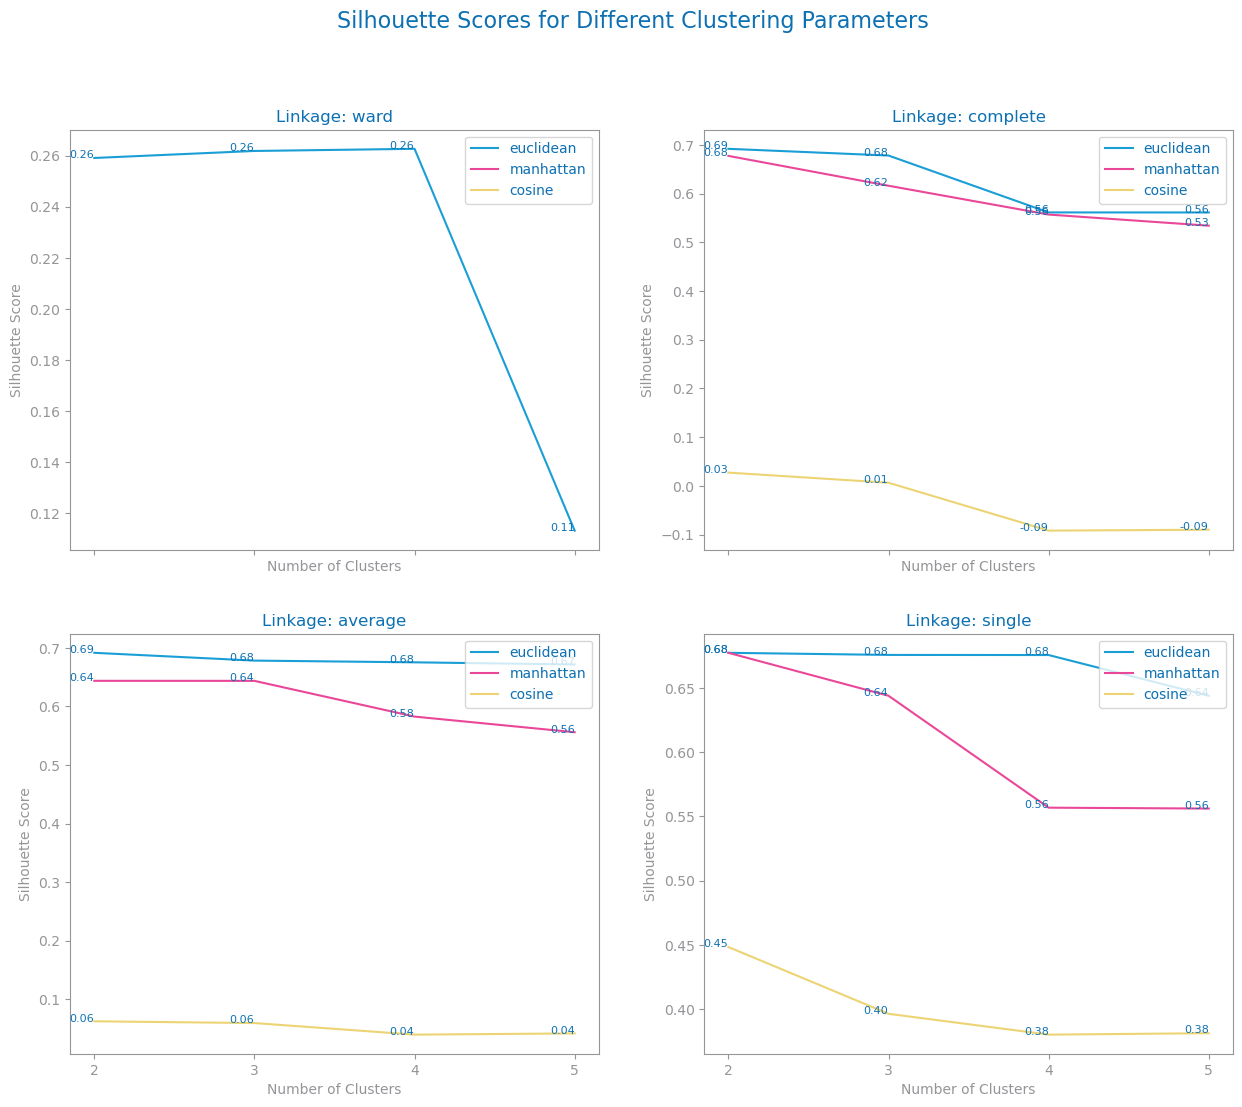

In [98]:
evaluate_agglomerative_clustering(user_aisle_scaled, scale='no')

#### aisle clustering creation

In [102]:

# affinity is loaded in data functions

aisle_agglo = AgglomerativeClustering(n_clusters=3,metric='euclidean', linkage='average' )
aisle_y_pred_agglo = aisle_agglo.fit_predict(user_aisle_scaled)

aisle_y_pred_agglo

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## aisle clustering evaluation

In [103]:
silhouette_kmeans = silhouette_score(user_aisle_scaled, aisle_y_pred_kmeans)
silhouette_agglo = silhouette_score(user_aisle_scaled, aisle_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')


Silhouette Score for KMeans: 0.1886884616288188
Silhouette Score for Agglomerative Clustering: 0.6784079904281584


## aisle cluster labeling

In [104]:
# Add cluster labels to the dataframe
aisle_df['kmeans_cluster'] = aisle_y_pred_kmeans
aisle_df['agglo_cluster'] = aisle_y_pred_agglo

# Display the dataframe with the new cluster labels
aisle_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,kmeans_cluster,agglo_cluster
user_id,,,,,,,,,,,,,,,,,,,,,
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
164,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
301,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## aisle labeling visualization

In [105]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = aisle_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = aisle_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0     759
1    2186
2      14
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    2957
1       1
2       1
dtype: int64


## aisle pca visualization

In [106]:
# Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca_aisle = PCA(n_components=6)
user_aisle_pca = pca_aisle.fit_transform(user_aisle_scaled)

pca_aisle_df = pd.DataFrame(user_aisle_pca, columns=[f'PC{i+1}' for i in range(user_aisle_pca.shape[1])])
pca_aisle_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.540109,-0.358397,0.066861,-0.213814,0.035981,-0.237460
1,-0.832977,-1.237716,-0.495883,-0.561453,0.519120,0.434231
2,4.775589,0.814354,0.927788,-0.279553,-0.601710,-0.178250
3,-1.524375,-0.589497,-0.131212,0.234935,0.070658,-0.125599
4,0.534594,1.327468,-1.538119,0.012865,0.751927,-0.341766


## user aisle pca explained variance ratio

In [107]:
# Fit the PCA model
pca_aisle.fit(user_aisle_scaled)

# Explained variance ratio
explained_variance_reorder = pca_aisle.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')

Explained variance ratio: [0.03219111 0.01832506 0.01651317 0.01411073 0.01290888 0.01221545]


## user aisle pca plot

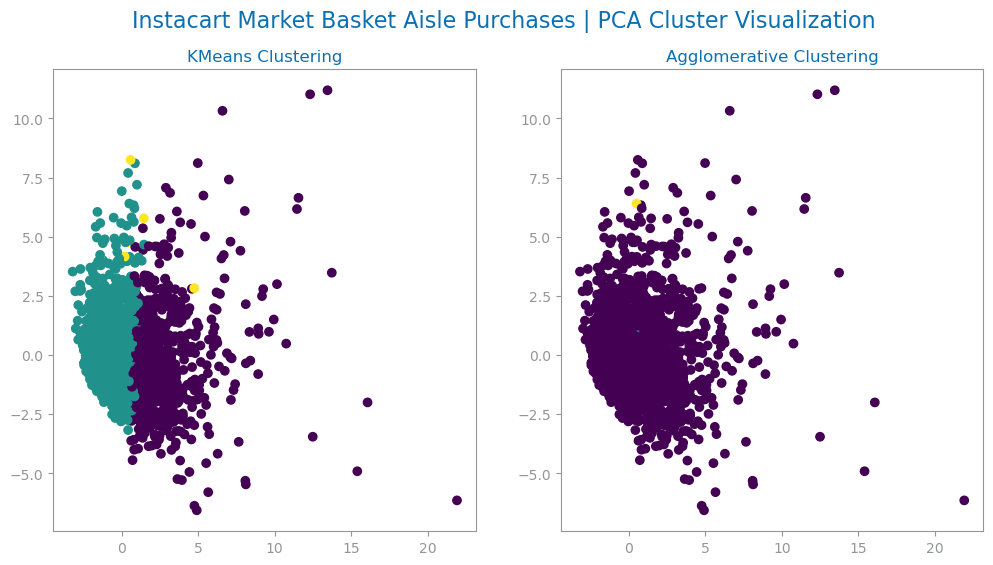

In [108]:

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=aisle_y_pred_kmeans)
plt.title(f'KMeans Clustering')

plt.subplot(122)
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=aisle_y_pred_agglo)
plt.title(f'Agglomerative Clustering')

plt.suptitle(f"{file_tag} Aisle Purchases | PCA Cluster Visualization", fontsize=16)

plt.show()

# Reorder Behaviour Clustering
- What are cart clusters that are more "refill" vs clusters where we have more "one shot order"?

## Reorder Data Prep

In [181]:
# Group by order_id and aggregate features
order_agg = data.groupby('order_id').agg({
    'add_to_cart_order': 'max',
    'reordered': 'mean'
}).rename(columns={'add_to_cart_order': 'num_products', 'reordered': 'reorder_rate'})

# Merge with orders data
order_data=data[['order_id','order_number','days_since_prior_order','is_weekend','weeks_since_prior_order','order_time_of_day_enc','order_hour_of_day_sin','order_hour_of_day_cos','order_dow_sin','order_dow_cos']].drop_duplicates()
       
order_agg = order_agg.merge(order_data, on='order_id')

# Dummify department IDs for reordered products
reordered = data[data['reordered'] == 1]
department_dummies = pd.get_dummies(reordered[['order_id', 'department']], columns=['department'])
department_dummies = department_dummies.groupby('order_id').sum().reset_index()

# Merge with aggregated order data
order_agg = order_agg.merge(department_dummies, on='order_id', how='left')

order_agg=order_agg.dropna()


order_agg

,order_id,num_products,reorder_rate,order_number,days_since_prior_order,is_weekend,weeks_since_prior_order,order_time_of_day_enc,order_hour_of_day_sin,order_hour_of_day_cos,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,411,6,0.833333,22,4.0,0,1.0,3.141593,-0.631088,-0.775711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,617,8,0.125000,3,20.0,0,3.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2047,3,0.666667,6,23.0,0,3.0,-1.570796,-0.979084,0.203456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2413,12,0.916667,50,7.0,0,1.0,-1.570796,-0.979084,0.203456,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,3229,2,0.500000,4,15.0,1,2.0,1.570796,0.398401,-0.917211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,3417813,15,0.533333,27,0.0,0,0.0,-1.570796,-0.519584,0.854419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
3006,3418250,17,0.882353,36,10.0,0,1.0,-1.570796,-0.887885,0.460065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
3007,3420047,8,1.000000,75,1.0,0,0.0,-1.570796,-0.997669,-0.068242,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
3008,3420404,11,0.090909,2,30.0,0,4.0,3.141593,-0.631088,-0.775711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reorder feature selection and scaling

In [182]:
# Select relevant features for clustering
reorder_numeric_features = order_agg[['num_products','reorder_rate','order_number','days_since_prior_order','is_weekend','weeks_since_prior_order','order_time_of_day_enc','order_hour_of_day_sin','order_hour_of_day_cos','order_dow_sin','order_dow_cos']
                             + list(department_dummies.columns[1:])
                            ]

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


## Reorder Clustering and evaluation

### reorder parameter tuning and studies

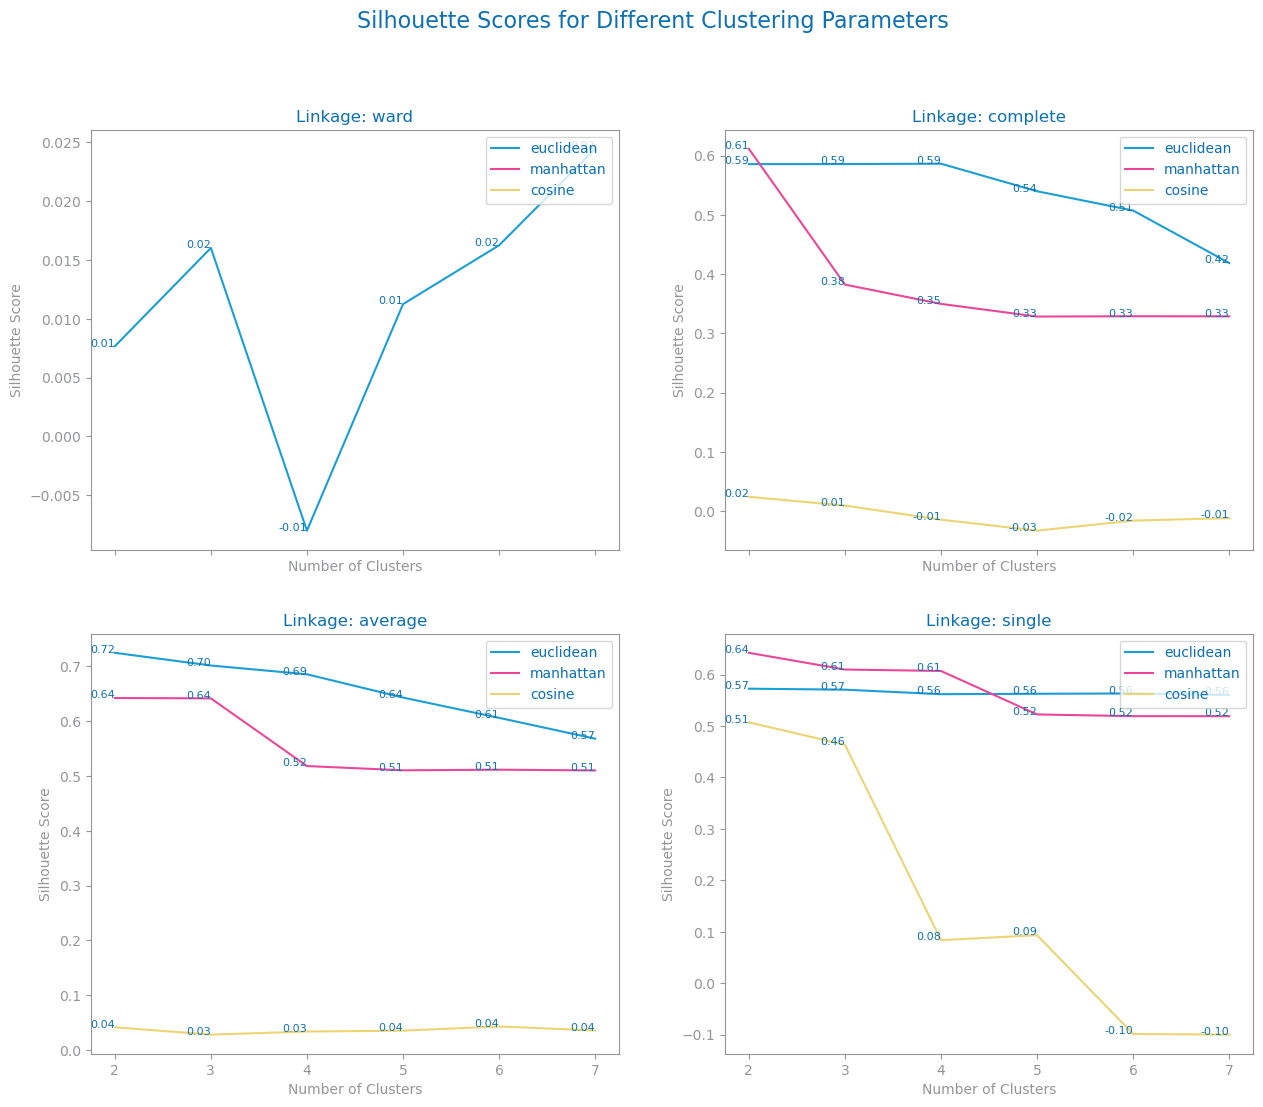

In [194]:
evaluate_agglomerative_clustering(reorder_numeric_features_scaled, n_clusters_list=[2, 3, 4, 5, 6, 7], scale='no')

### Reorder kmeans clustering

In [195]:
# Clustering
reorder_kmeans = KMeans(n_clusters=4, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

### Reorder agglomerative clustering

In [196]:
reorder_agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

## Reorder Evaluation

In [197]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')

# Extrinsic Evaluation
target = order_agg['reorder_rate']
adjusted_rand_kmeans = adjusted_rand_score(target.round(), reorder_y_pred_kmeans)
adjusted_rand_agglo = adjusted_rand_score(target.round(), reorder_y_pred_agglo)

print(f'Adjusted Rand Index for KMeans: {adjusted_rand_kmeans}')
print(f'Adjusted Rand Index for Agglomerative Clustering: {adjusted_rand_agglo}')

Silhouette Score for KMeans: 0.06748384148203204
Silhouette Score for Agglomerative Clustering: 0.701457067736002
Adjusted Rand Index for KMeans: -8.121662341624498e-05
Adjusted Rand Index for Agglomerative Clustering: -0.001533440942175297


## Reorder Cluster Labeling

In [198]:
# Add cluster labels to the dataframe
order_agg['kmeans_cluster'] = reorder_y_pred_kmeans
order_agg['agglo_cluster'] = reorder_y_pred_agglo

# Display the dataframe with the new cluster labels
order_agg.head()

,order_id,num_products,reorder_rate,order_number,days_since_prior_order,is_weekend,weeks_since_prior_order,order_time_of_day_enc,order_hour_of_day_sin,order_hour_of_day_cos,...,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,kmeans_cluster,agglo_cluster
0,411,6,0.833333,22,4.0,0,1.0,3.141593,-0.631088,-0.775711,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,0
1,617,8,0.125000,3,20.0,0,3.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
2,2047,3,0.666667,6,23.0,0,3.0,-1.570796,-0.979084,0.203456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2413,12,0.916667,50,7.0,0,1.0,-1.570796,-0.979084,0.203456,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
4,3229,2,0.500000,4,15.0,1,2.0,1.570796,0.398401,-0.917211,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0


### Reorder Cluster Counts

In [199]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = order_agg.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = order_agg.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0     403
1     661
2     480
3    1289
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    2829
1       2
2       2
dtype: int64


### reorder cluster boxplots

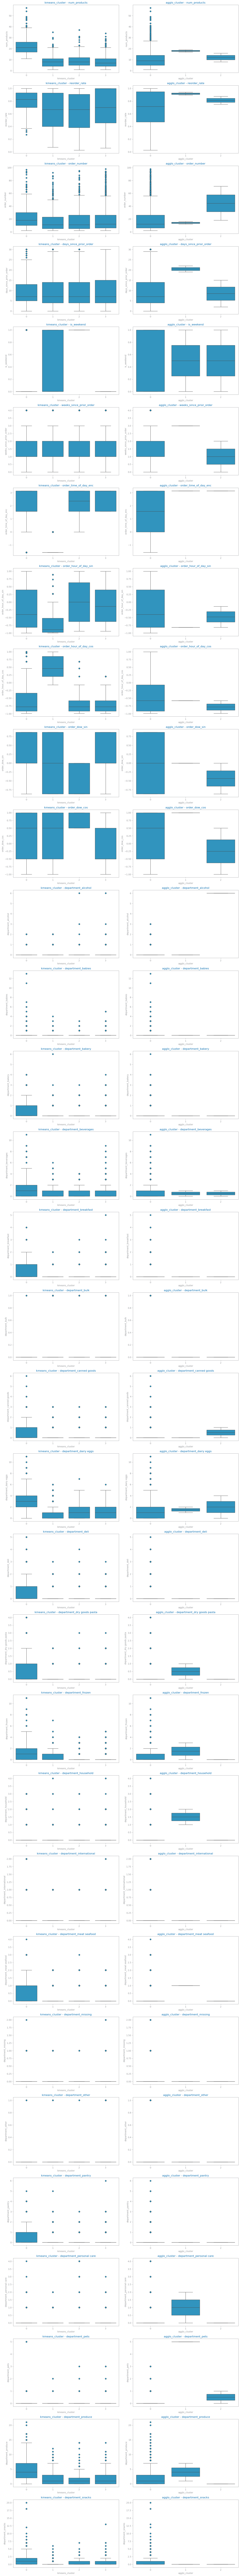

In [201]:

# Example usage
features = reorder_numeric_features.columns
cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(order_agg, features, cluster_labels)

## Reorder PCA visualization

In [189]:
# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.420502,-1.184704,-0.572300,-0.218149,0.187265,-0.178162
1,-1.966073,1.968416,-1.772745,-0.658872,-0.521930,0.294671
2,-2.404953,1.531796,1.501559,-0.893768,1.849770,2.853116
3,2.150285,-1.037066,2.244397,-2.252443,-0.173262,-1.118392
4,-2.022936,0.848876,-0.939884,1.898363,-0.480055,-0.279441


## reorder pca explained variance ratio

In [190]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.1062922  0.07315145 0.06067283 0.05300626 0.04079067 0.03614725]


## reorder pca plot

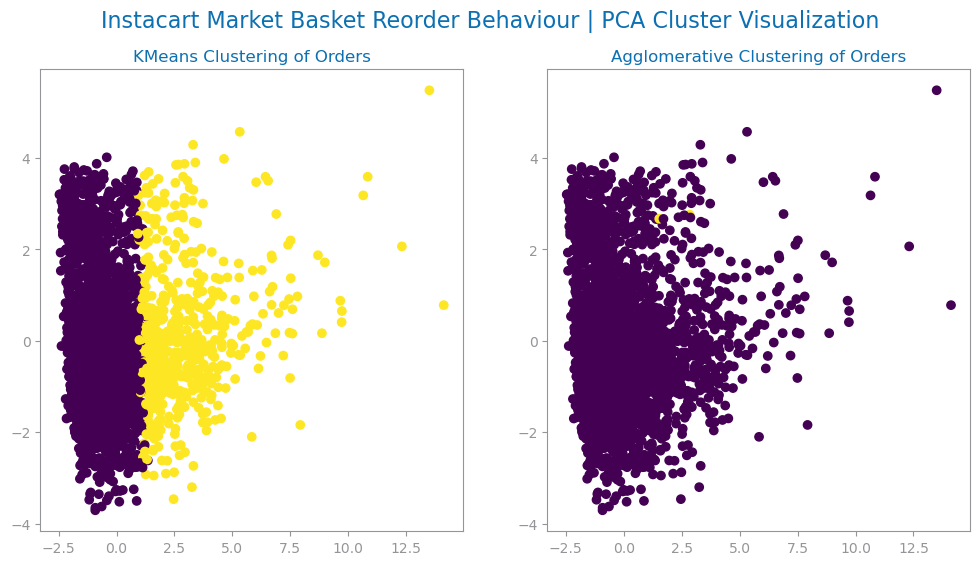

In [191]:

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=reorder_y_pred_kmeans)
plt.title('KMeans Clustering of Orders')

plt.subplot(122)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=reorder_y_pred_agglo)
plt.title('Agglomerative Clustering of Orders')


plt.suptitle(f"{file_tag} Reorder Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
should we separate clusters by reordered vs not reordered?